# Derivative for Regression

In [1]:
from __future__ import (print_function, division)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import rbf_kernel
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
colormap = plt.cm.get_cmap('coolwarm')
from time import time
import warnings
from krr import KRR, rbf_derivative
from rbf_derivative_cy import rbf_derivative as rbf_derivative_cy
import scipy as scio
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky

### Parameters

In [2]:
# standard parameters
num_points = 5000
train_size = 0.7
random_state = None
linear_coef = 1
num_noise_coefs = 5
noise_scale = 0.05

# get data
x_data = np.linspace(0, 3*np.pi, num_points)
x_data = x_data[:, np.newaxis]

NoiseGenerator = check_random_state(random_state)

y_data = linear_coef * np.sin(x_data) +  \
    NoiseGenerator.normal(scale=noise_scale, size=x_data.shape)
    
# split data (training, testing)
x_train, x_test, y_train, y_test = \
    train_test_split(x_data, y_data, train_size=train_size,
                     random_state=random_state)

/Users/eman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Kernel Ridge Regerssion (KRR)

In [3]:
# parameter heuristics
mean_sigma = np.mean(pdist(x_train, metric='euclidean'))
mean_gamma = 1 / (2 * mean_sigma ** 2)
lam = 0.01

# construct kernel matrices
K_train = rbf_kernel(X=x_train, gamma=mean_gamma)
K_test = rbf_kernel(X=x_train, Y=x_data, gamma=mean_gamma)

# Slow method: solve problem
t0 = time()
alpha = scio.linalg.solve(K_train + lam * np.eye(x_train.shape[0]), 
                          y_train)
t1 = time() - t0
print('Time taken for normal solver: {:.4f} secs'.format(t1))


# project the data
y_pred = (K_test.T @ alpha).squeeze()

Time taken for normal solver: 0.8847 secs


### 1st Derivative

In [4]:
# derivative parameters
x_train = np.float64(x_train)
x_function = np.float64(x_data)
kernel_mat = np.float64(rbf_kernel(x_train, x_data, 
                                   gamma=mean_gamma))
support_vectors = np.float64(alpha).squeeze()
mean_gamma = np.float64(mean_gamma)
n_derivative = 1

# Python Implementation
t0 = time()
derivative = rbf_derivative(x_train=x_train,
                            x_function=x_function,
                            kernel_mat=kernel_mat,
                            weights=support_vectors,
                            gamma=mean_gamma,
                            n_derivative=n_derivative)
t1_python = time() - t0
print('Time taken for Python: {:.4f} secs'.format(t1_python))


# Cython Implementation
t0 = time()
derivative_cy = rbf_derivative_cy(x_train=x_train,
                                  x_function=x_function,
                                  kernel_mat=kernel_mat,
                                  weights=support_vectors,
                                  gamma=mean_gamma,
                                  n_derivative=n_derivative)
t1_cython = time() - t0
print('Time taken for Cython: {:.4f} secs'.format(t1_cython))

print('\nSpeedup: x{:.2f}'.format(t1_python/t1_cython))
print('\nAll values are the same:',
      np.allclose(derivative, derivative_cy))

Time taken for Python: 24.0855 secs
Time taken for Cython: 1.5986 secs

Speedup: x15.07

All values are the same: True


In [5]:
# t_python = %timeit -o rbf_derivative(x_train=x_train,x_function=x_function,kernel_mat=kernel_mat,weights=support_vectors,gamma=mean_gamma,n_derivative=n_derivative)
# t_cython = %timeit -o rbf_derivative_cy(x_train=x_train,x_function=x_function,kernel_mat=kernel_mat,weights=support_vectors,gamma=mean_gamma,n_derivative=n_derivative)

# print('\nSpeedup: {}'.format(t_python.best/t_cython.best))

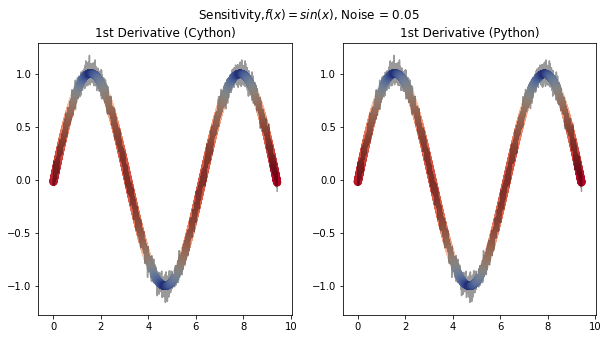

In [6]:
# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# calculate the sensitivity
sens1 = np.abs(derivative_cy).squeeze()
sens2 = np.abs(derivative).squeeze()


# Plot the first derivative
ax[0].plot(x_data, y_data, 'k', alpha=0.4, label=u'$f(X)$')
ax[0].scatter(x_data, y_pred, s=50, c=sens1, cmap=colormap)

# plot the second derivative
ax[1].plot(x_data, y_data, 'k', alpha=0.4, label=u'$f(X)$')
ax[1].scatter(x_data, y_pred, s=50, c=sens2, cmap=colormap)


# set titles
plt.suptitle(u'Sensitivity,$f(x)=sin(x)$, Noise = 0.05')
ax[0].set_title(u'1st Derivative (Cython)')
ax[1].set_title(u'1st Derivative (Python)')

plt.show()

### 2nd Derivative

In [7]:
n_derivative = 2

# Python Implementation
t0 = time()
derivative2 = rbf_derivative(x_train=x_train,
                             x_function=x_function,
                             kernel_mat=kernel_mat,
                             weights=support_vectors,
                             gamma=mean_gamma,
                             n_derivative=n_derivative)
t1_python = time() - t0
print('Time taken for Python: {:.4f} secs'.format(t1_python))


# Cython Implementation
t0 = time()
derivative2_cy = rbf_derivative_cy(x_train=x_train,
                                   x_function=x_function,
                                   kernel_mat=kernel_mat,
                                   weights=support_vectors,
                                   gamma=mean_gamma,
                                   n_derivative=n_derivative)
t1_cython = time() - t0
print('Time taken for Cython: {:.4f} secs'.format(t1_cython))

print('\nSpeedup: x{:.2f}'.format(t1_python/t1_cython))
print('\nAll values are the same:',
      np.allclose(derivative2, derivative2_cy))

Time taken for Python: 33.5637 secs
Time taken for Cython: 1.9348 secs

Speedup: x17.35

All values are the same: True


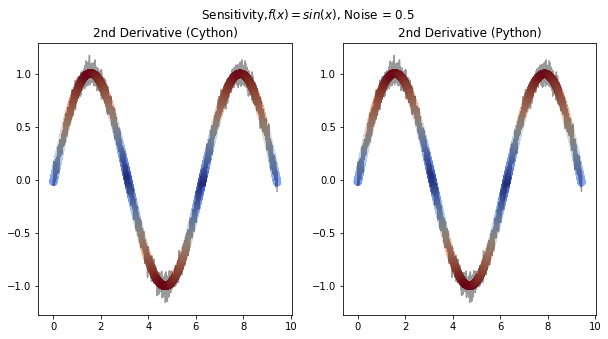

In [8]:
# Plot the results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# calculate the sensitivity
sens1 = np.abs(derivative2_cy).squeeze()
sens2 = np.abs(derivative2).squeeze()


# Plot the first derivative
ax[0].plot(x_data, y_data, 'k', alpha=0.4, label=u'$f(X)$')
ax[0].scatter(x_data, y_pred, s=50, c=sens1, cmap=colormap)

# plot the second derivative
ax[1].plot(x_data, y_data, 'k', alpha=0.4, label=u'$f(X)$')
ax[1].scatter(x_data, y_pred, s=50, c=sens2, cmap=colormap)


# set titles
plt.suptitle(u'Sensitivity,$f(x)=sin(x)$, Noise = 0.5')
ax[0].set_title(u'2nd Derivative (Cython)')
ax[1].set_title(u'2nd Derivative (Python)')

plt.show()